<a href="https://colab.research.google.com/github/Rohan1511/LearningGit/blob/main/importing_data_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing Dataset in Google Collab from Google Drive

#### Its easy, store your data in your drive and then import in collab using package gdown

In [1]:
import gdown #Library used 
import os as os #To navigate in folders

After Importing libraries, we see the structure of how files are stored here. In the left you can see a folder symbol. Check it out ! Think of it as your local folder where you can store all the data. 

Let's start with how to create a folder and then import your data from drive to here.  The idea here is to make a new directory if there is already not one.

In [2]:
# print('Your Current Working directory is :' + os.getcwd()) #Current working directory. 
# dir_name = 'NASA_flood2021'
# if os.path.isdir(dir_name) is False: #is there a directory; 1 'yes or True' otherwise 0
#   os.mkdir(dir_name)                 # Make directory
# else: 
#   print(dir_name + '  already Exists') #Print if the if condition is not satisfied

In [3]:
# check if files are already downloaded
dset_download = os.path.isdir('/content/ETCI_2021_Competition_Dataset/train/')

if dset_download is False:
  url = 'https://drive.google.com/uc?id=14HqNW5uWLS92n7KrxKgDwUTsSEST6LCr'
  output = 'train.tgz'
  gdown.download(url, output, quiet=False)

  url = 'https://drive.google.com/uc?id=1GWl3g1G152Rinxc1Fbc-JkSWlRQNWKBK'
  output = 'valid.tgz'
  gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14HqNW5uWLS92n7KrxKgDwUTsSEST6LCr
To: /content/train.tgz
3.23GB [00:32, 99.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GWl3g1G152Rinxc1Fbc-JkSWlRQNWKBK
To: /content/valid.tgz
873MB [00:14, 59.4MB/s]


## Move and Unzip files

In [7]:
if dset_download is False:
  !mkdir -p /content/ETCI_2021_Competition_Dataset # -p is for parent directory
  
  !mv /content/train.tgz /content/ETCI_2021_Competition_Dataset/
  !mv /content/valid.tgz /content/ETCI_2021_Competition_Dataset/
  


In [8]:
import zipfile
with zipfile.ZipFile('/content/ETCI_2021_Competition_Dataset/train.tgz', 'r') as zip_ref:
  zip_ref.extractall('/content/ETCI_2021_Competition_Dataset/')


In [9]:

with zipfile.ZipFile('/content/ETCI_2021_Competition_Dataset/valid.tgz', 'r') as zip_ref:
  zip_ref.extractall('/content/ETCI_2021_Competition_Dataset/')


Set path to where dataset is downloaded

In [10]:
#Set path to where dataset is downloaded
dset_root = '/content/ETCI_2021_Competition_Dataset/'

In [11]:
# get number of training/validation regions
from glob import glob #Navigating directories

train_dir = os.path.join(dset_root, 'train') # saving full path
valid_dir = os.path.join(dset_root, 'val')

n_train_regions = len(glob(train_dir+'/*/')) #Counting directories inside 
n_valid_regions = len(glob(valid_dir+'/*/'))

# NOTE: make sure number of regions is NOT 0
print('Number of training temporal-regions: {}'.format(n_train_regions))
print('Number of validation temporal-regions: {}'.format(n_valid_regions))

Number of training temporal-regions: 31
Number of validation temporal-regions: 10


In [12]:

def get_filename(filepath):
    return os.path.split(filepath)[1]


def visualize(df_row, figsize=[25, 15]):
    # get image paths
    vv_image_path = df_row['vv_image_path']
    vh_image_path = df_row['vh_image_path']
    flood_label_path = df_row['flood_label_path']
    water_body_label_path = df_row['water_body_label_path']

    # create RGB image from S1 images
    rgb_name = get_filename(vv_image_path)
    vv_image = cv2.imread(vv_image_path, 0) / 255.0
    vh_image = cv2.imread(vh_image_path, 0) / 255.0
    rgb_image = s1_to_rgb(vv_image, vh_image)

    # get water body label mask
    water_body_label_image = cv2.imread(water_body_label_path, 0) / 255.0

    # plot images
    plt.figure(figsize=tuple(figsize))
    if df_row.isnull().sum() > 0:
        # plot RGB S1 image
        plt.subplot(1,2,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot water body mask
        plt.subplot(1,2,2)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')
    else:
        flood_label_image = cv2.imread(flood_label_path, 0) / 255.0

        # plot RGB S1 image
        plt.subplot(1,3,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot flood label mask
        plt.subplot(1,3,2)
        plt.imshow(flood_label_image)
        plt.title('Flood mask')

        # plot water body mask
        plt.subplot(1,3,3)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')


def s1_to_rgb(vv_image, vh_image):
    ratio_image = np.clip(np.nan_to_num(vh_image/vv_image, 0), 0, 1)
    rgb_image = np.stack((vv_image, vh_image, 1-ratio_image), axis=2)
    return rgb_image

def visualize_result(df_row, prediction, figsize=[25, 15]):
    vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
    vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0
    rgb_input = s1_to_rgb(vv_image, vh_image)

    plt.figure(figsize=tuple(figsize))
    plt.subplot(1,2,1)
    plt.imshow(rgb_input)
    plt.title('RGB w/ result')
    plt.subplot(1,2,2)
    plt.imshow(prediction)
    plt.title('Result')

# Create training and validation Dataframes

In [13]:
# Navigate through directories and get all the vv paths, vvnames and region names
import pandas as pd

vv_image_paths = sorted(glob(train_dir+'/**/vv/*.png', recursive=True)) 
vv_image_names = [get_filename(pth) for pth in vv_image_paths] 
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]


vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
    # get vh image path
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path
    flood_image_name = vv_image_names[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths.append(flood_label_path)

    # get water body mask path
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

    # get region name
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)


train_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}


train_df = pd.DataFrame(train_paths)

print(train_df.shape)
train_df.head()

(33405, 5)


,vv_image_path,vh_image_path,flood_label_path,water_body_label_path,region
0,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,bangladesh
1,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,bangladesh
2,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,bangladesh
3,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,bangladesh
4,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,bangladesh


In [20]:
vv_image_paths = sorted(glob(valid_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]


vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
    # get vh image path
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(valid_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path ()
    flood_label_paths.append(np.NaN)

    # get water body mask path
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(valid_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

    # get region name
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)

valid_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}


valid_df = pd.DataFrame(valid_paths)
valid_df.sort_values(by=['vv_image_path'])  # important line for submitting results

print(valid_df.shape)
valid_df.head()

(10400, 5)


,vv_image_path,vh_image_path,flood_label_path,water_body_label_path,region
0,/content/ETCI_2021_Competition_Dataset/val/flo...,/content/ETCI_2021_Competition_Dataset/val/flo...,NaN,/content/ETCI_2021_Competition_Dataset/val/flo...,florence
1,/content/ETCI_2021_Competition_Dataset/val/flo...,/content/ETCI_2021_Competition_Dataset/val/flo...,NaN,/content/ETCI_2021_Competition_Dataset/val/flo...,florence
2,/content/ETCI_2021_Competition_Dataset/val/flo...,/content/ETCI_2021_Competition_Dataset/val/flo...,NaN,/content/ETCI_2021_Competition_Dataset/val/flo...,florence
3,/content/ETCI_2021_Competition_Dataset/val/flo...,/content/ETCI_2021_Competition_Dataset/val/flo...,NaN,/content/ETCI_2021_Competition_Dataset/val/flo...,florence
4,/content/ETCI_2021_Competition_Dataset/val/flo...,/content/ETCI_2021_Competition_Dataset/val/flo...,NaN,/content/ETCI_2021_Competition_Dataset/val/flo...,florence


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


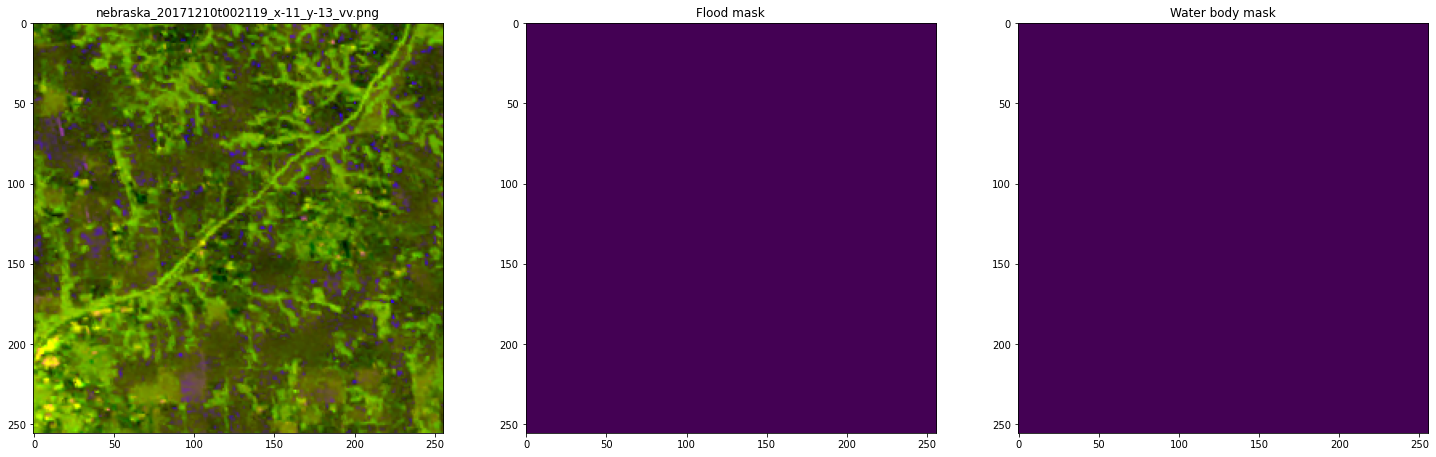

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
visualize(train_df.iloc[16501])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


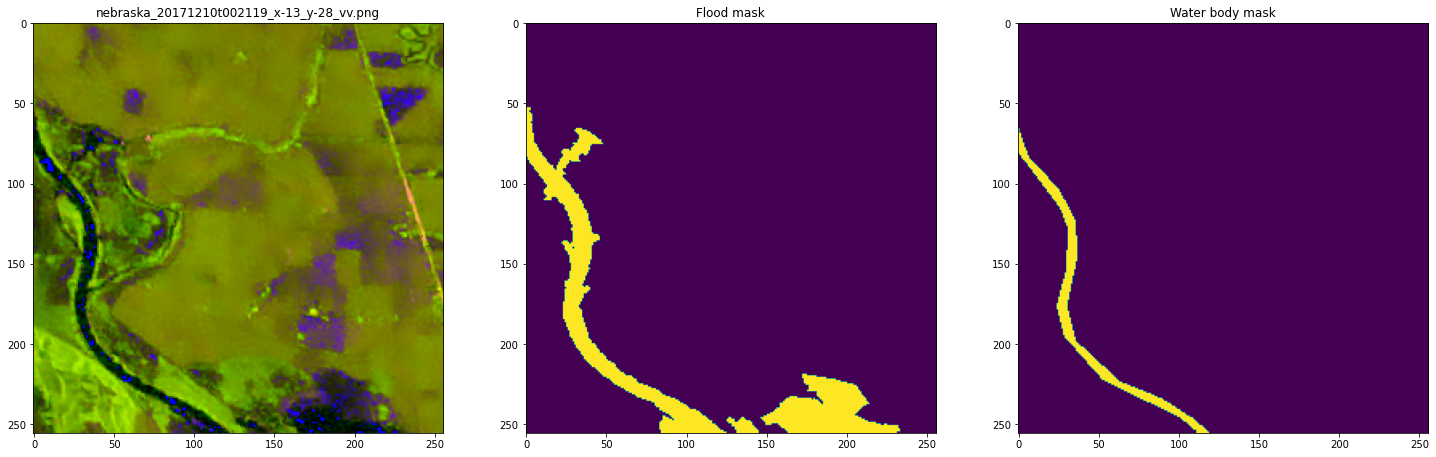

In [18]:
visualize(train_df.iloc[16601])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


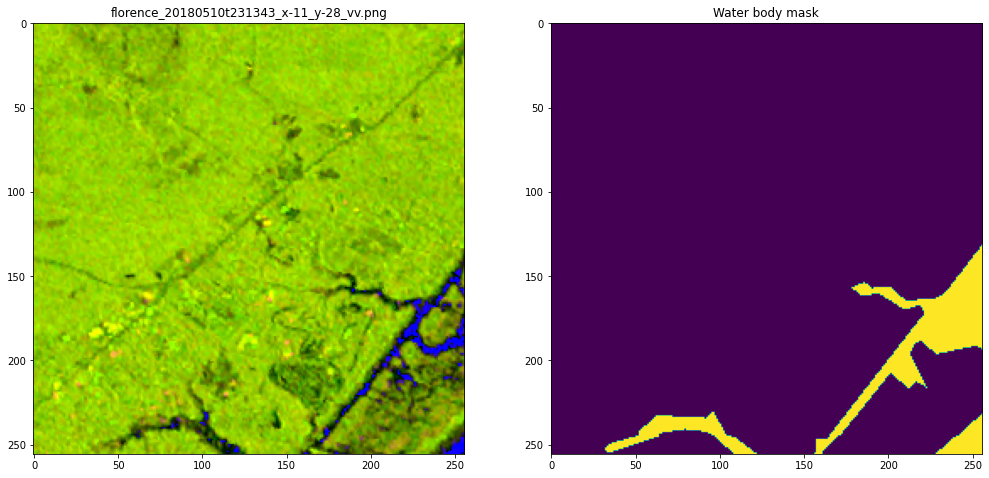

In [21]:
visualize(valid_df.iloc[100], figsize=(17,10))

In [23]:
#@title Default title text
# Since we do not have flood labels for the validation set of this dataset, we will not be able to fairly evaluate our trained model for the flood segmentation task. Instead we can split our training dataset (that contains flood masks) into a smaller training and development set. We will leave the true validation set for inference in another section.


In [24]:
# all regions in the training set
regions = ['nebraska', 'northal', 'bangladesh']

# randomly choose one for the development set and leave the rest for training
development_region = np.random.choice(regions, 1)[0]
regions.remove(development_region)
train_regions = regions

print('Training regions: {}'.format(train_regions))
print('Development region: {}'.format(development_region))

Training regions: ['nebraska', 'northal']
Development region: bangladesh


In [25]:
# filter the dataframe to only get images from specified regions
sub_train_df = train_df[train_df['region'] != development_region]
development_df = train_df[train_df['region'] == development_region]

In [26]:
# check that new dataframes only have the image paths from the correct regions
print('Sub-training set regions: {}'.format(np.unique(sub_train_df['region'].tolist())))
print('Development set region: {}'.format(np.unique(development_df['region'].tolist())))

Sub-training set regions: ['nebraska' 'northal']
Development set region: ['bangladesh']
